# Score-based methods: improvements and new features

`sbi` incorporates recent algorithms based on Score Matching generative models. This is encoded in the `NPSE` class (Neural Posterior Score Estimation).

In this tutorial, we will show how to use NPSE and highlight the new functionalities of score-based methods with a toy example.

For more information, see:

**Score Matching**:

- Hyvärinen, A. "Estimation of Non-Normalized Statistical Models by Score Matching." JMLR 2005.

- Song, Y., et al. "Score-Based Generative Modeling through Stochastic Differential Equations." ICLR 2021.

- Geffner, T., Papamakarios, G., and Mnih, A. "Score modeling for simulation-based inference." NeurIPS 2022 Workshop on Score-Based Methods. 2022.

- Sharrock, L., Simons, J., et al. "Sequential neural score estimation: Likelihood-free inference with conditional score based diffusion models." ICML 2024.

- Karras, T.,  Aittala, M., et al. "Elucidating the Design Space of Diffusion-Based Generative Models." NeurIPS 2022.

- Linhart J., et al. "Diffusion posterior sampling for simulation-based inference in tall data settings." 2024


## Key concepts of NPSE
NPSE approximates a target posterior distribution $p_0(\theta|x_0)$ by learning its score function, i.e., the gradient of the log-density of the (diffused) posterior $\nabla_{\theta}\log p_t(\theta|x)$, for all times $t$ and all conditional observations $x$, using the denoising score matching loss. Score-based generative models are indeed closely linked to diffusion models, especially during the sampling phase.

Note that only the **single-round** version of NPSE is implemented currently.

Sampling from the target posterior $p_0(\theta|x_0)$ can be split into two steps:
- *forward* step: diffuse samples from $p_0(\theta|x_0)$ over time and learn the diffused scores, i.e., $\nabla_{\theta}\log p_t(\theta|x)$ for all $t \in [0,t_{\max}]$. At the end ($t=t_{\max}$) the diffused posterior is really close to a standard Gaussian.
- *reverse* step: reverse the diffusion process, starting from a standard Gaussian, using the learned scores to get new samples from $p_0(\theta|x_0)$.

We first introduce sampling for a posterior given a **single** observation $x_0$, and then for the **tall** posterior (when $x_0$ is a batch of i.i.d. observations).

## Single observation

In this section, $x_0$ is a single observation. We define a simple simulator in 2D.

In [1]:
import matplotlib.pyplot as plt
import torch
from torch.distributions import MultivariateNormal

from sbi.analysis import pairplot
from sbi.inference import NPSE

In [2]:
# Example toy simulator
# Define the prior
num_dims = 2
num_simulations = 5000
prior = MultivariateNormal(loc=torch.zeros(num_dims), covariance_matrix=torch.eye(num_dims))

def simulator(theta):
    """Linear gaussian simulator."""
    return theta + 1.0 + torch.randn_like(theta) * 0.1

# Produce simulations
theta = prior.sample((num_simulations,))
x = simulator(theta)

# Ground truth parameter/observation
theta_o = torch.zeros(num_dims)
x_o = simulator(theta_o)

In [3]:
# Instantiate NPSE and append simulations
inference = NPSE(prior=prior, sde_type="vp")
inference.append_simulations(theta, x)

The argument `sde_type` defines whether the forward diffusion process has a noising schedule that is Variance Exploding (`ve`, i.e., [SMLD](https://proceedings.neurips.cc/paper/2019/hash/3001ef257407d5a371a96dcd947c7d93-Abstract.html?ref=https://githubhelp.com)), Variance Preserving (`vp`, i.e., [DDPM](https://proceedings.neurips.cc/paper/2020/hash/4c5bcfec8584af0d967f1ab10179ca4b-Abstract.html)), or sub-Variance Preserving (`subvp`) in the limit.

The current default noising schedule is `ve`. As we care more about sampling quality than sampling times in our example, we choose to work with the `vp` option.

### Training

In [4]:
# Train the score estimator
score_estimator = inference.train()

 Neural network successfully converged after 141 epochs.

The method `train` calls the denoising score-matching loss corresponding to the chosen noising schedule (VE, VP, subVP). As the variance of the loss may be high, especially for times $t$ near $0$, **control variates** are automatically used in the expression of the loss.  

After training, we obtain an **amortized** score estimator that approximates the score of the diffused posterior distribution for all times $t \in [t_{\min},t_{\max}]$ and **any** conditional observation $x$, i.e. $\nabla_{\theta}\log p_t(\theta|x)$.  
We can use these score estimates to reverse the diffusion process and sample from the target distribution.

### Sampling procedures

In [5]:
# Build the posterior using the trained score estimate, and sample with the sde option
posterior = inference.build_posterior(score_estimator, sample_with="sde")
samples = posterior.sample((10000,), x=x_o, predictor="euler_maruyama", corrector="langevin", steps=100)

  0%|          | 0/10000 [00:00<?, ?it/s]

Generating 10000 posterior samples in 99 diffusion steps.:   0%|          | 0/99 [00:00<?, ?it/s]

The argument `sample_with` allows you to choose which kind of solver you want to use to reverse the diffusion equation:

- `"ode"` : builds the probability flow ODE using the zuko library. We can sample from the flow afterwards by calling `.sample()`

- `"sde"` : solves the reverse SDE by alternating **prediction** and **correction** steps  

Both options contain **rejection sampling** steps to ensure prior coverage.  
Note that in the `"sde"` option, the only available predictor is `"euler_maruyama"` and the available correctors are `"langevin"` (for **Unadjusted Langevin Dynamics**) and `"gibbs"` (for **Gibbs sampling** often referred to as "self-recurrence" in the literature of diffusion models).  

The argument `x_o` in the `.sample()` method indicates which observation is set before sampling from the corresponding posterior and replaces the `.set_default_x()` method.

### MAP estimation
It is possible to get a Maximum A Posteriori (MAP) estimate in the case of score-based methods. Note that in this case, you should **first** set the default observation, using the `set_default_x()` method!  
The optimization procedure (gradient ascent) aims at finding a maximizer $\theta_{\max}$ of the posterior log-probability $\log p(\theta|x_0)$.   
The optimization can be interrupted at any time if the user sees that the log-probability converges: the best estimate will still be saved and can be accessed with `.map()`.  

The default values used by this function (e.g. number of optimization steps, number of starting positions, learning rate) might require hand-tuning from the user for the problem at hand.

As it is expensive to frequently calculate the gradient of the "density" (as this requires the "neural ODE" formulation), notice that the network itself will learn this gradient! So we instead use a forward pass through the network at $t_{\min}$

In [6]:
# MAP estimation
posterior.set_default_x(x_o)
map_est = posterior.map(num_iter=10, learning_rate=0.1)
print("The MAP estimate is : ", map_est)

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating 1000 posterior samples in 499 diffusion steps.:   0%|          | 0/499 [00:00<?, ?it/s]

The MAP estimate is :  tensor([[ 0.0737, -0.0314]])


In [7]:
map_est

tensor([[ 0.0737, -0.0314]])

The argument `num_iter` indicates the number of optimization steps (gradient ascent) that the algorithm takes to find the MAP. In our simple example, a small number of iterations is sufficient for the log-probability (of the posterior) to converge.

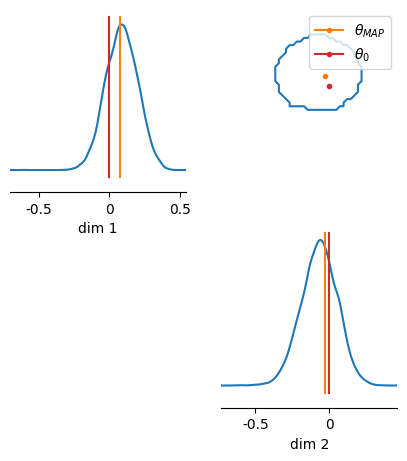

In [8]:
# Plot posterior samples and MAP
fig, ax = pairplot(
    samples,figsize=(5, 5),
    diag = "kde",
    upper="contour",
    diag_kwargs=dict(bins=100),
    upper_kwargs=dict(levels=[0.95]),
    points=[map_est,theta_o.unsqueeze(0)], # add ground truth thetas and MAP
    fig_kwargs=dict(
        points_offdiag={"markersize": 6}
    )
)
ax[0][1].legend([r"$\theta_{MAP}$",r"$\theta_0$"], loc="upper right")#, bbox_to_anchor=[2.0, 1.0, 0.0, 0.0]);
plt.sca(ax[1, 1]);

### Batched sampling
Given a batch of observations $[x_1, \ldots, x_B]$ (not necessarily i.i.d.), it is also possible to get samples from posteriors $p(\theta|x_1)$, ..., $p(\theta|x_B)$, in a vectorized manner and without retraining the score network! This is implemented in the `.sample_batched()` method of the posterior.  
The argument `sample_shape` specifies the desired number of samples for **each** posterior.

In [9]:
# Sample in a vectorized manner from different posteriors
num_obs = 5
theta_batch = prior.sample((num_obs,)) # get 5 different parameters
x_batch = simulator(theta_batch) # get 5 corresponding obs
posterior_batched_samples = posterior.sample_batched(sample_shape=(100,), x=x_batch)
print("The size of the batched samples is : ", posterior_batched_samples.size())

Drawing 100 samples for 5 observations:   0%|          | 0/100 [00:00<?, ?it/s]

Generating 100 posterior samples in 499 diffusion steps.:   0%|          | 0/499 [00:00<?, ?it/s]

The size of the batched samples is :  torch.Size([100, 5, 2])


## Score-based methods for i.i.d. data

In this section, $x_0$ is a batch of **i.i.d.** observations, $x_0=[x_0^0,\ldots,x_0^N]$. It is possible to sample from the *tall* posterior distribution $p(\theta|x_0^0,\ldots,x_0^N)$ using `NPSE` trained for **individual** observations!

Once the score estimate is trained (see previous section), sampling from $p(\theta|x_0^0,\ldots,x_0^N)$ is split into two steps:

- estimate the scores of the *tall* posterior for all times $t$ based on the learned scores of **individual** posteriors $p(\theta|x_0^i)$ for all $i$. $4$ different methods are implemented for now.

- reverse the diffusion process or perform Langevin dynamics using the estimated scores  

Note that in this i.i.d. setting, only the `"sde"` option for sampling is implemented for now.  

In the example, we will draw different observations from the same parameter $\theta_0$ and see how the posterior evolves with an increasing number of conditional observations.


In [10]:
# Build the tall posterior, and sample using sde option
posterior = inference.build_posterior(score_estimator, prior=prior, sample_with="sde")
x_iid = simulator(theta_o.repeat(20,1))

# Sample from a posterior conditioned with 5 observations
tall_samples_5_obs = posterior.sample(sample_shape=(1000,), x=x_iid[:5,:], iid_method="gauss")
# Sample from a posterior conditioned with 10 observations
tall_samples_10_obs = posterior.sample(sample_shape=(1000,), x=x_iid[:10,:], iid_method="gauss")
# Sample from a posterior conditioned with 20 observations
tall_samples_20_obs = posterior.sample(sample_shape=(1000,), x=x_iid, iid_method="gauss")

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating 1000 posterior samples in 499 diffusion steps.:   0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating 1000 posterior samples in 499 diffusion steps.:   0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating 1000 posterior samples in 499 diffusion steps.:   0%|          | 0/499 [00:00<?, ?it/s]

Note that the posterior object created by the `.build_posterior()` is essentially the same as in the previous section (with single observations).  
  
To sample, we call `.sample()` as before but we now pass a **batch** of observations to the argument `x`: the algorithm will assume those to be i.i.d. and automatically switch to the i.i.d. setting.  

The argument `iid_method` only applies when `x` is a **batch** of observations.  
It specifies the method used to estimate the scores of the *tall* posterior at different times $t$ using the scores of individual posteriors. For now, the available options are:

- `"jac_gauss"`, `"gauss"` and `"auto_gauss"` (see [Linhart et al., 2024](https://arxiv.org/abs/2404.07593) for more details)

- `"fnpe"`, standing for Factorized Neural Posterior Estimation (see [Geffner et al., 2023](https://arxiv.org/abs/2209.14249) for more details).

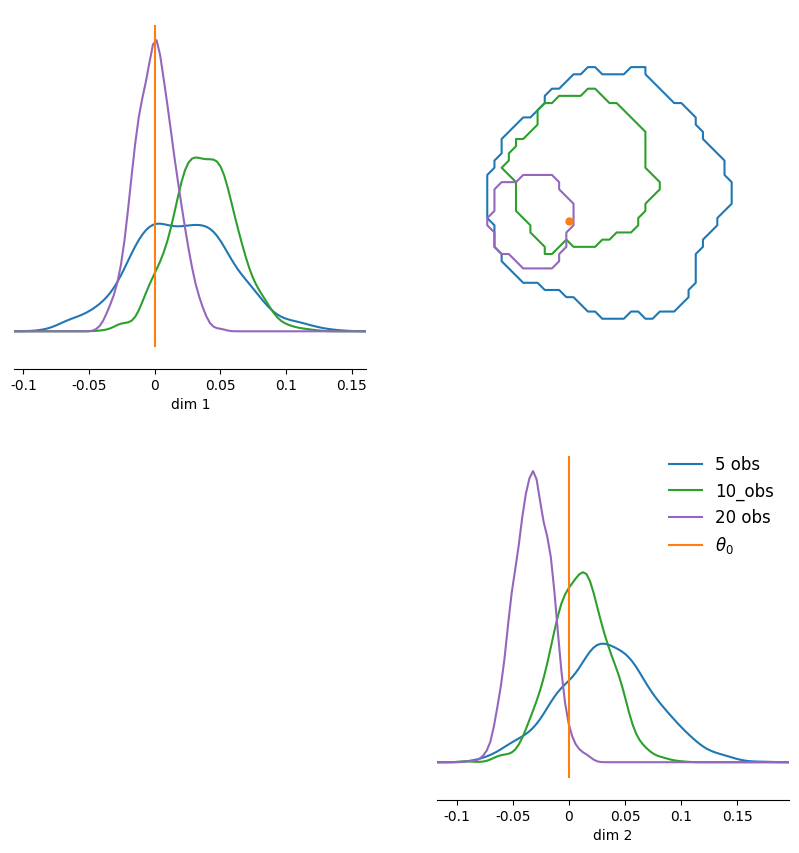

In [11]:
# Plot the samples and the ground truth parameter
fig, ax = pairplot(
    samples=[tall_samples_5_obs,tall_samples_10_obs,tall_samples_20_obs],
    figsize=(10, 10),
    points=theta_o.unsqueeze(0),
    diag="kde",
    upper="contour",
    diag_kwargs=dict(bins=100),
    upper_kwargs=dict(levels=[0.95]),
    fig_kwargs=dict(
        #points_colors=["k"],
        points_offdiag=dict(markersize=10),
    ),
)
plt.sca(ax[1, 1])
plt.legend(
    ["5 obs", "10_obs","20 obs"]
    + [r"$\theta_0$"],
    frameon=False,
    fontsize=12,
);

As expected, the posterior concentrates around the ground truth parameter $\theta_0$ as the number of i.i.d. conditional observations increases.

# Score-based guidance methods for post-hoc modifications

We might want to do certain modifications to our model after training, e.g.:
- Shifting prior/likelihood location/scale.
- Truncating the prior.
- Changing the prior to a different distribution.

A way to do this is **guidance**, and there is an API, as well as a few pre-implemented methods, to perform such operations.
For example, the following *classifier-free guidance* method allows you to shift and scale the prior and likelihood.

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating 1000 posterior samples in 499 diffusion steps.:   0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating 1000 posterior samples in 499 diffusion steps.:   0%|          | 0/499 [00:00<?, ?it/s]

(<Figure size 800x800 with 4 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >],
        [<Axes: xlabel='dim 1'>, <Axes: xlabel='dim 2'>]], dtype=object))

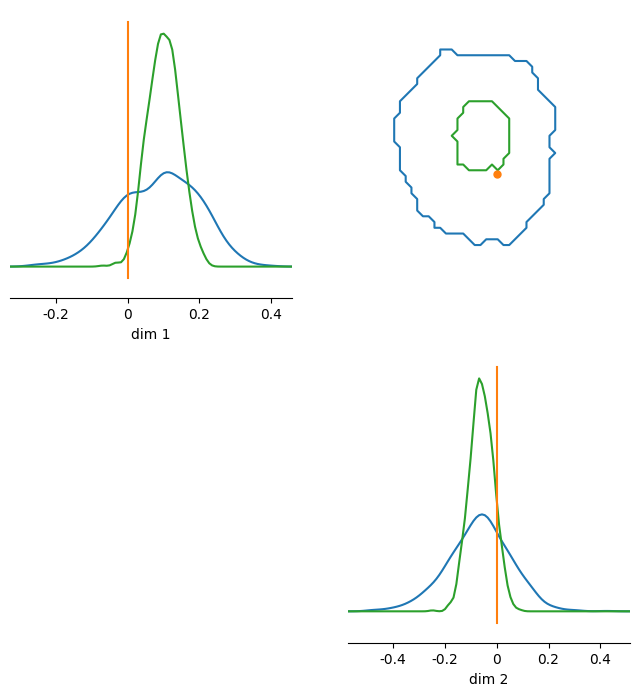

In [12]:
guidance_params = {
    "likelihood_scale": 4.0,  # increase the likelihood precision (-> narrower posterior)
    "prior_scale": 1.,  # same prior precision
    "prior_shift": 0.,  # same prior mean
    "likelihood_shift": 0.,  # same likelihood mean
}

samples_unguided = posterior.sample((1000,), x=x_o)
samples_guided = posterior.sample(
        (1000,),
        x=x_o,
        guidance_method="affine_classifier_free",
        guidance_params=guidance_params,
    )
pairplot(
    [samples_unguided, samples_guided],
    points=theta_o.unsqueeze(0),
    figsize=(8, 8),
    diag="kde",
    upper="contour",
    diag_kwargs=dict(bins=100),
    upper_kwargs=dict(levels=[0.95]),
)

The above is quite limited in terms of the modifications we can do. A more general method is **prior-guidance** which allows to specify arbitrary training and test priors (see https://arxiv.org/pdf/2510.13763).
The only requirement is that the "test" prior should be somewhat covered by the "training" prior (i.e. the prior used during training). Otherwise we will guide the samples outside the training distribution and the score estimates will be very poor.

Below we can exchange the training prior (i.e. standard normal) for a shifted multivariate normal prior with strong correlations.

In [15]:
train_prior = MultivariateNormal(loc=torch.zeros(num_dims), covariance_matrix=torch.eye(num_dims))
test_prior = MultivariateNormal(loc=torch.zeros(num_dims) + 0.1, covariance_matrix=torch.tensor([[0.2, 0.19],[0.19,0.2]]))
guidance_params = {
    "test_prior": test_prior,
    "train_prior": train_prior,
    "K": 8, # For more complicated adjustments we need a larger K.
    "covariance_type": "full"  # Required for adding new correlations!
}

samples_unguided = posterior.sample((1000,), x=x_o)
samples_guided = posterior.sample(
        (1000,),
        x=x_o,
        guidance_method="prior_guide",
        guidance_params=guidance_params,
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating 1000 posterior samples in 499 diffusion steps.:   0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating 1000 posterior samples in 499 diffusion steps.:   0%|          | 0/499 [00:00<?, ?it/s]

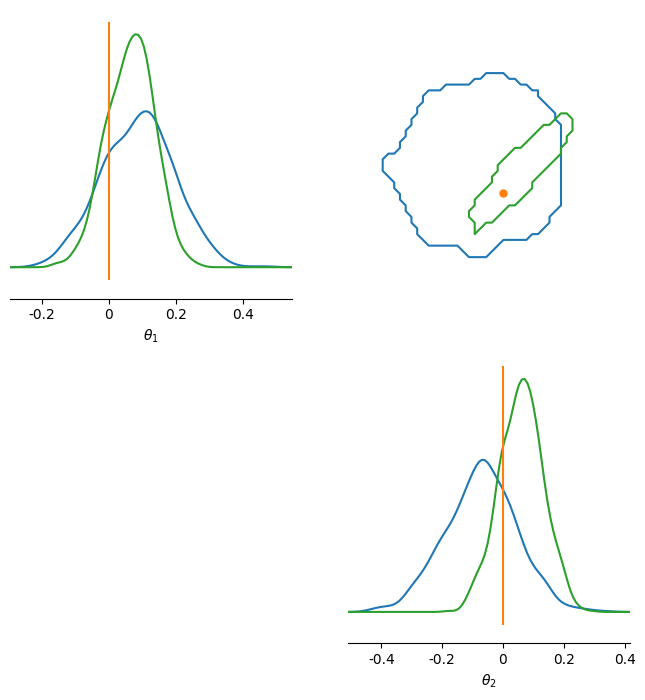

In [16]:
pairplot(
    [samples_unguided, samples_guided],
    points=theta_o.unsqueeze(0),
    figsize=(8, 8),
    diag="kde",
    upper="contour",
    diag_kwargs=dict(bins=100),
    upper_kwargs=dict(levels=[0.95]),
    labels=[r"$\theta_1$", r"$\theta_2$"],
);